In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd

In [3]:
data_path = '/home/brazhe/yandex-disk/data-tmp/'

In [4]:
ls $data_path/*.csv

/home/brazhe/yandex-disk/data-tmp//17.10.19.car2.csv
/home/brazhe/yandex-disk/data-tmp//17.10.19.cardrive.csv
/home/brazhe/yandex-disk/data-tmp//17.10.19.walking.csv
/home/brazhe/yandex-disk/data-tmp//lefthand-open.csv
/home/brazhe/yandex-disk/data-tmp//lefthand-shut.csv


In [5]:
from swan import utils as swu

In [6]:
from sklearn import manifold as skm
from sklearn import decomposition as skd

## Hand hold

Question to test: can we discriminate (see differences) between accelerometer data recorded with eyes open and eyes shut?

In [7]:
open_data = pd.read_csv(data_path+'lefthand-open.csv')

In [8]:
shut_data = pd.read_csv(data_path+'lefthand-shut.csv')

In [9]:
open_data.describe()

,time,x,y,z,gforce
count,23974.000000,23974.000000,23974.00000,23974.000000,23974.000000
mean,23.703735,-0.123517,0.07222,0.970395,0.985390
std,13.715534,0.081989,0.04993,0.050823,0.054248
min,0.018000,-0.833000,-0.55100,0.322000,0.376000
25%,11.829750,-0.152000,0.05800,0.955000,0.968000
50%,23.664000,-0.117000,0.07300,0.972000,0.983000
75%,35.560500,-0.082000,0.09100,0.988000,0.999000
max,47.522000,0.258000,0.23900,1.537000,1.603000


In [10]:
shut_data.describe()

,time,x,y,z,gforce
count,37242.000000,37242.000000,37242.000000,37242.000000,37242.000000
mean,36.951465,-0.206449,0.088970,0.949226,0.984365
std,21.411470,0.117066,0.056509,0.050142,0.044791
min,0.010000,-0.725000,-0.448000,0.080000,0.209000
25%,18.385250,-0.303000,0.064000,0.923000,0.967000
50%,36.876500,-0.220000,0.107000,0.947000,0.984000
75%,55.498250,-0.124000,0.125000,0.974000,1.000000
max,74.111000,0.165000,0.343000,1.437000,1.442000


Text(0.5, 0, 'time, s')

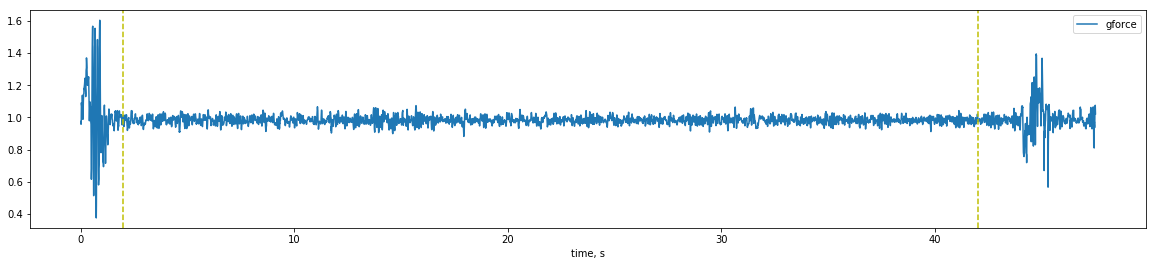

In [11]:
figure(figsize=(20,4))
open_data.plot(x='time', y='gforce',ax=gca())
axvline(2, color='y',ls='--')
axvline(42, color='y',ls='--')
xlabel('time, s')

Text(0.5, 0, 'time, s')

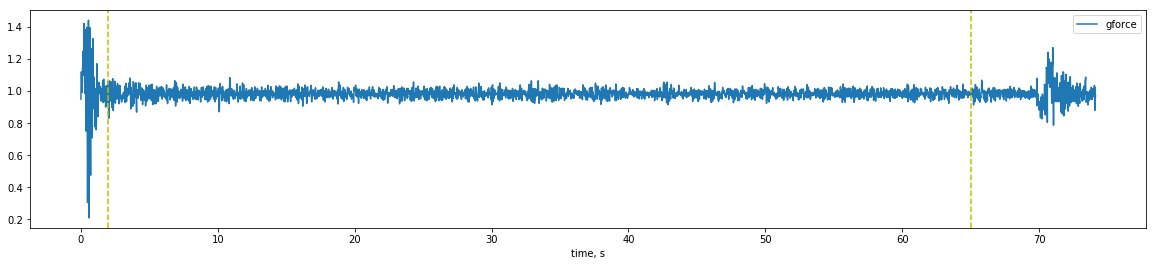

In [12]:
figure(figsize=(20,4))
shut_data.plot(x='time', y='gforce',ax=gca())
axvline(2, color='y',ls='--')
axvline(65, color='y',ls='--')
xlabel('time, s')

In [13]:
open_data = open_data[(open_data.time < 42) & (open_data.time > 2)]

In [14]:
shut_data = shut_data[(shut_data.time < 65) & (shut_data.time > 2)]

We need to separate our data to *training* and *test* data sets. So we test our assumptions on a different piece of data than the algorithm has been trained on

In [15]:
dt = mean(diff(open_data.time))

In [16]:
print('Sampling interval: %0.2f ms'%(dt*1000))

Sampling interval: 1.98 ms


In [17]:
%matplotlib qt

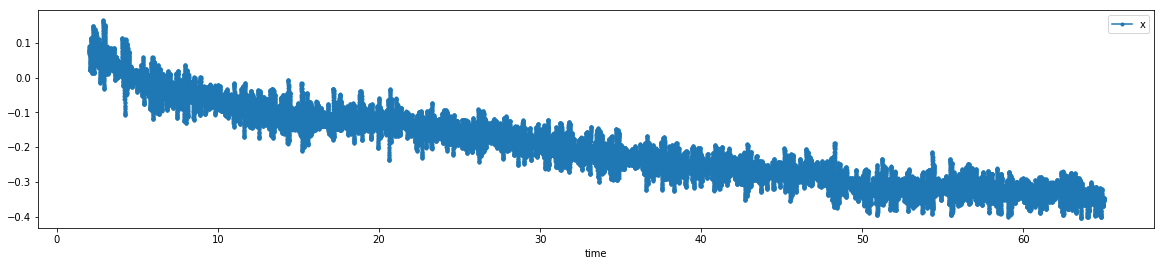

In [18]:
figure(figsize=(20,4))
shut_data.plot(x='time', y='x',ax=gca(), ls='-',marker='.')

In [19]:
from swan import utils as swu

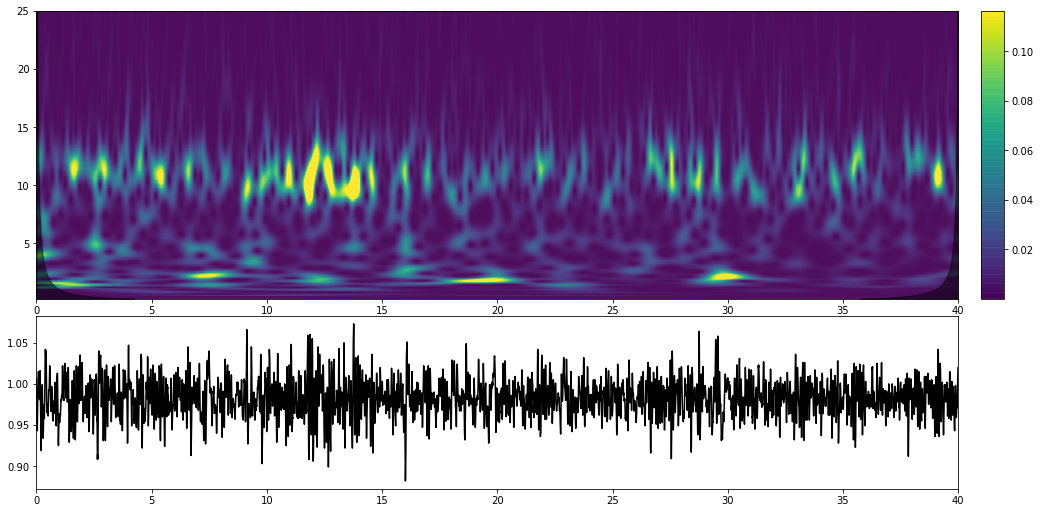

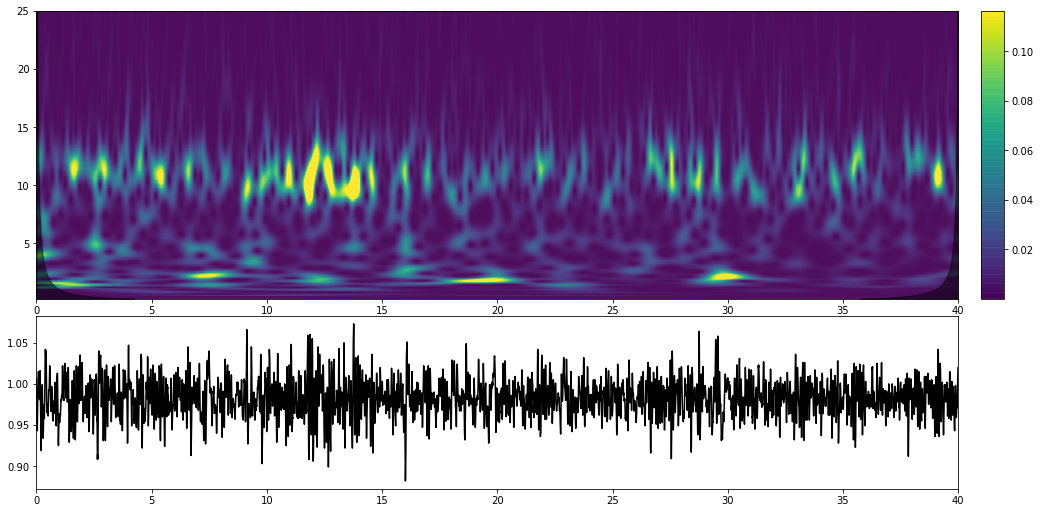

In [20]:
swu.plot_spectrogram_with_ts(open_data.gforce[:-1], f_s = 1/dt, 
                             figsize=(16,8),
                             freqs=linspace(0.25,25,512),cmap='viridis',padding='reflect')
gcf()

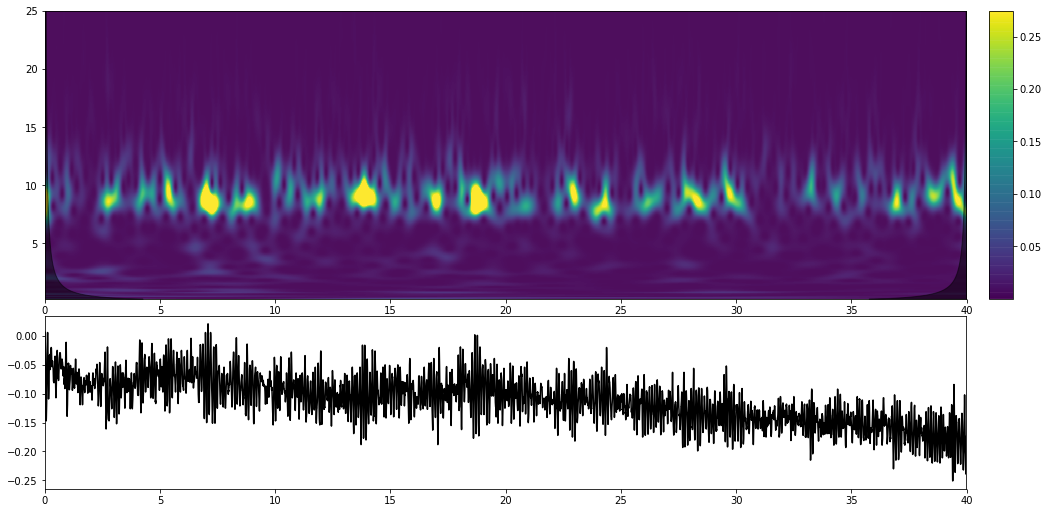

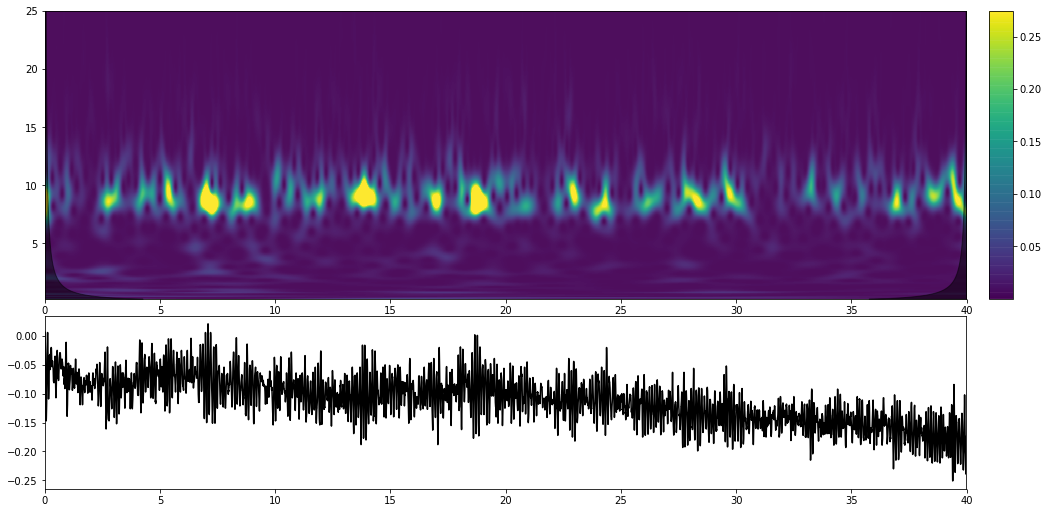

In [21]:
swu.plot_spectrogram_with_ts(open_data.x[:-1], f_s = 1/dt, 
                             figsize=(16,8),
                             freqs=linspace(0.25,25,512),cmap='viridis',padding='reflect')
gcf()

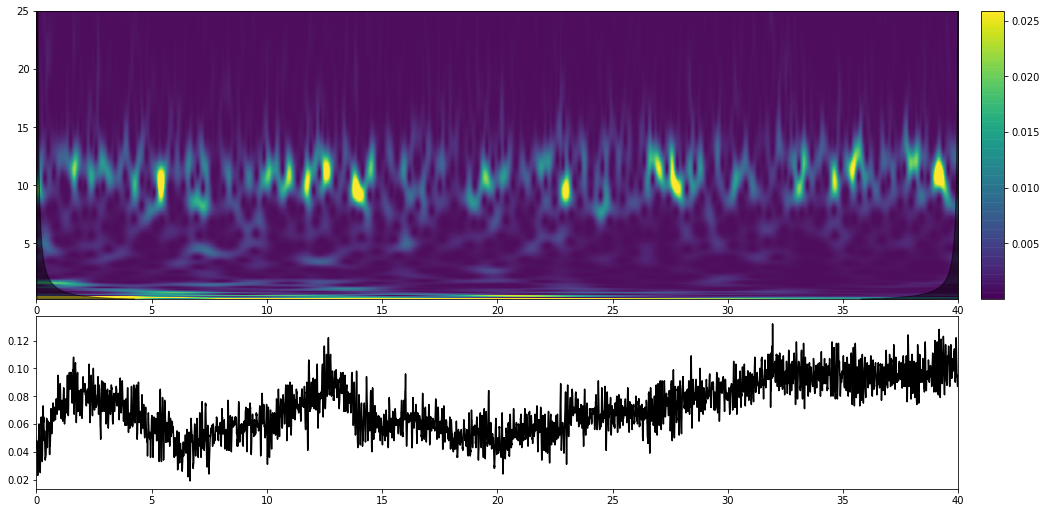

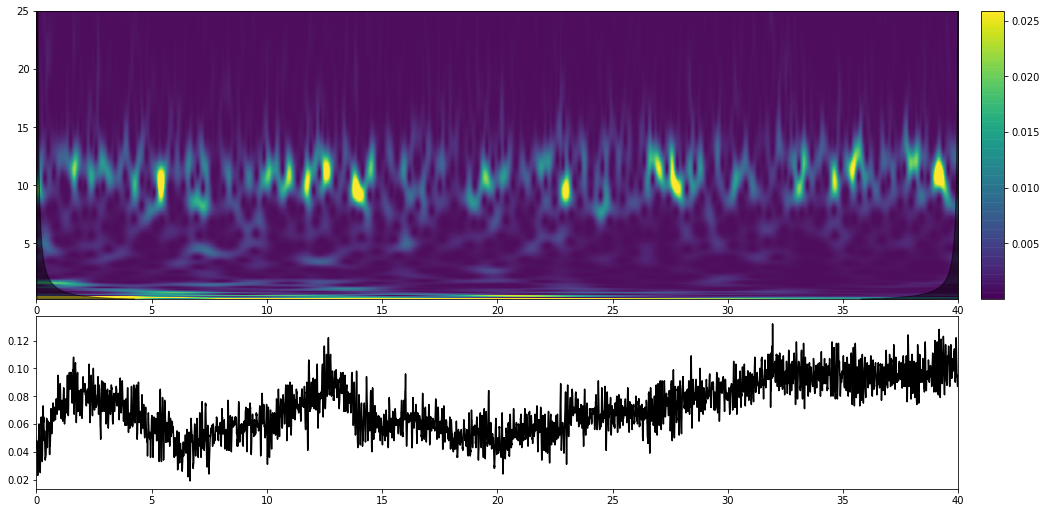

In [22]:
swu.plot_spectrogram_with_ts(open_data.y[:-1], f_s = 1/dt, 
                             figsize=(16,8),
                             freqs=linspace(0.25,25,512),cmap='viridis',padding='reflect')
gcf()

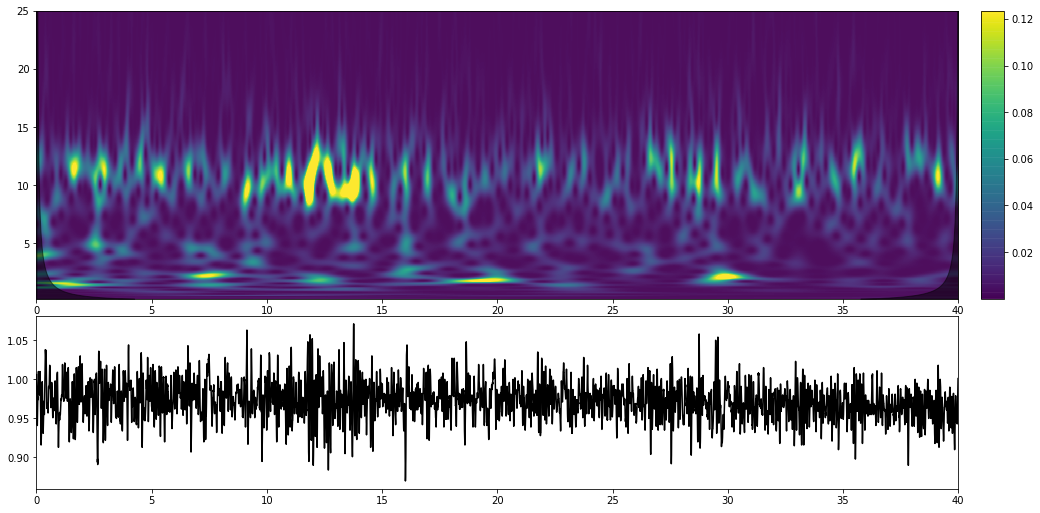

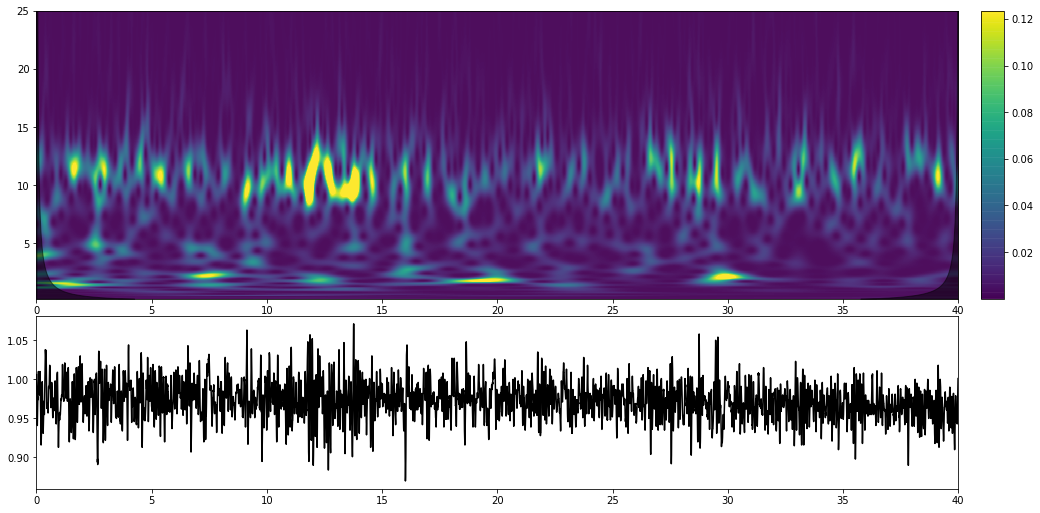

In [23]:
swu.plot_spectrogram_with_ts(open_data.z[:-1], f_s = 1/dt, 
                             figsize=(16,8),
                             freqs=linspace(0.25,25,512),cmap='viridis',padding='reflect')
gcf()

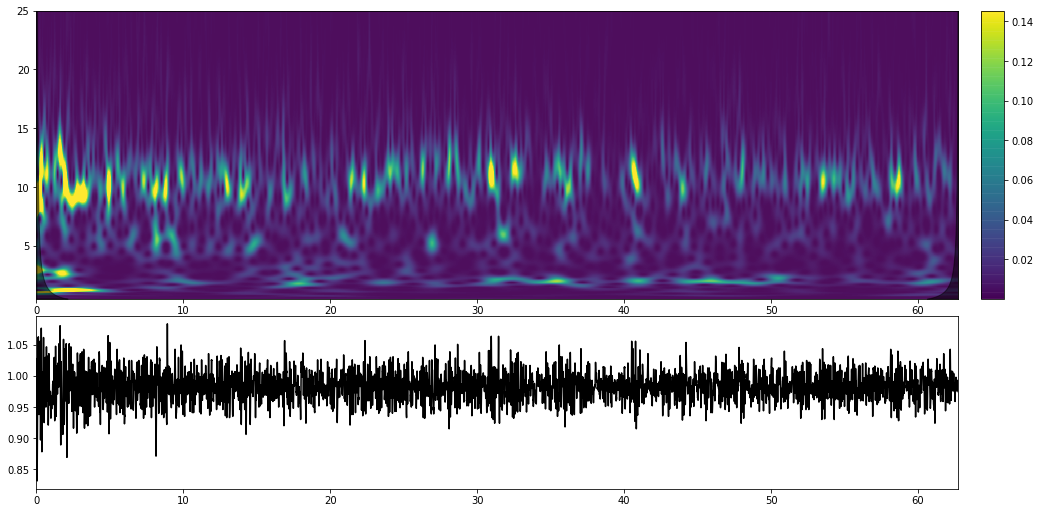

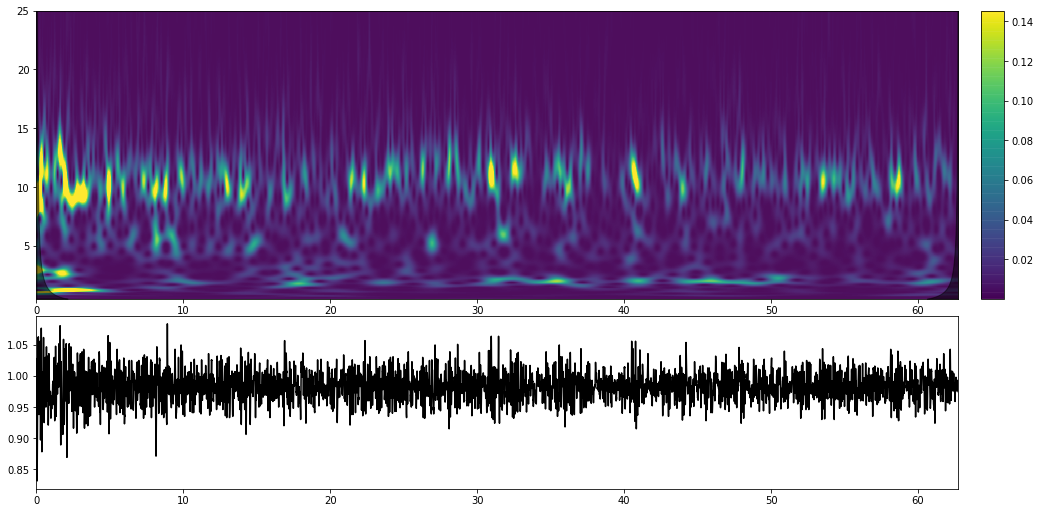

In [24]:
swu.plot_spectrogram_with_ts(shut_data.gforce, f_s = 1/dt, 
                             figsize=(16,8),
                             freqs=linspace(0.5,25,512),cmap='viridis',padding='reflect')
gcf()

In [25]:
close('all')

Our test data will be the last 10 seconds of each recording

In [26]:
def standardize(x):
    return (x-x.mean(0))/x.std(0)

def split_data(df, sep=10):
    cond =  df.time >= df.time.max()-sep
    train,test = df[~cond], df[cond]
    convert = lambda x: array(x)[:,1:] # convert to array and throw away time column
    return standardize(convert(train)), standardize(convert(test))

In [27]:
open_train, open_test = split_data(open_data)
shut_train, shut_test = split_data(shut_data)

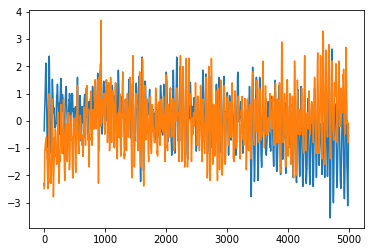

In [28]:
plot(open_test[:,0])
plot(open_test[:,1])

In [29]:

%time u,s,vh = svd(open_train, full_matrices=False)

CPU times: user 5.05 ms, sys: 0 ns, total: 5.05 ms
Wall time: 1.18 ms


In [30]:
%time tSVD = skd.TruncatedSVD(n_components=2, algorithm='arpack') #exact algorithm

CPU times: user 12 µs, sys: 0 ns, total: 12 µs
Wall time: 16.2 µs


In [31]:
coords = tSVD.fit_transform(open_train)
coords_test = tSVD.transform(open_test)

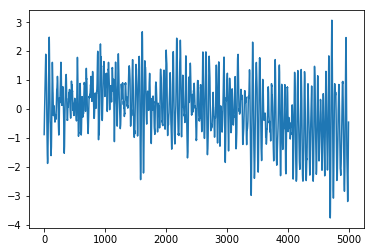

In [32]:
plot(coords_test[:,1])

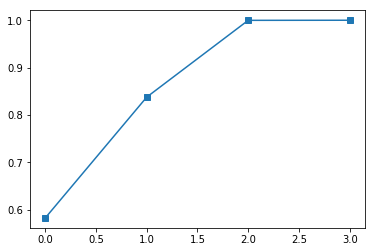

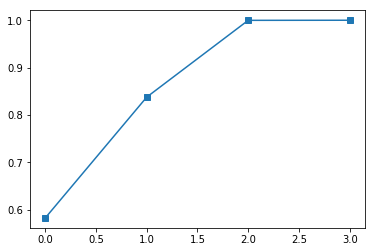

In [33]:
figure();
plot(cumsum(s**2)/np.sum(s**2),'s-')
gcf()

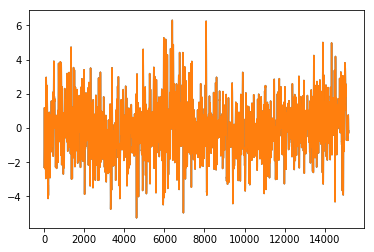

In [34]:
figure();
plot(u[:,0]*s[0])
plot(coords[:,0])

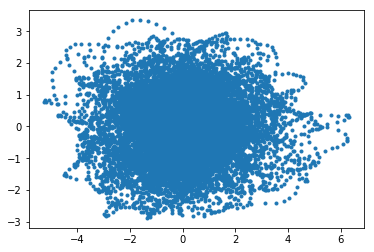

In [35]:
figure()
plot(coords[:,0],coords[:,1],'.')

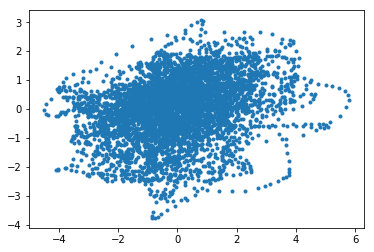

In [36]:
plot(coords_test[:,0],coords_test[:,1],'.')

##  Learning from patches

In [37]:
def extract_random_slice(arr,L=2000):
    N = len(arr)
    start = randint(0, N-L)
    cut =  arr[start:start+L]
    return cut - cut.mean(0)

In [38]:
train_slices_open = [ravel(extract_random_slice(open_train)) for n in range(4000)]
train_slices_shut = [ravel(extract_random_slice(shut_train)) for n in range(4000)]

In [39]:
test_slices_open = [ravel(extract_random_slice(open_test)) for n in range(4000)]
test_slices_shut = [ravel(extract_random_slice(shut_test)) for n in range(4000)]

In [40]:
train_data = vstack(train_slices_open + train_slices_shut)
test_data = vstack(test_slices_open + test_slices_shut)

In [41]:
train_data.shape

(8000, 8000)

In [42]:
Ltrain, Ltest = len(train_data), len(test_data)

**todo:** compare approximate and exact SVD algorithms

In [43]:
tSVD = skd.TruncatedSVD(25)

In [44]:
%time tSVD.fit(train_data)

CPU times: user 4.5 s, sys: 235 ms, total: 4.74 s
Wall time: 1.35 s


TruncatedSVD(algorithm='randomized', n_components=25, n_iter=5,
       random_state=None, tol=0.0)

In [45]:
%time coords_test = tSVD.transform(test_data)

CPU times: user 370 ms, sys: 95 µs, total: 370 ms
Wall time: 91.9 ms


In [46]:
%time coords = tSVD.transform(train_data)

CPU times: user 370 ms, sys: 151 µs, total: 370 ms
Wall time: 92.6 ms


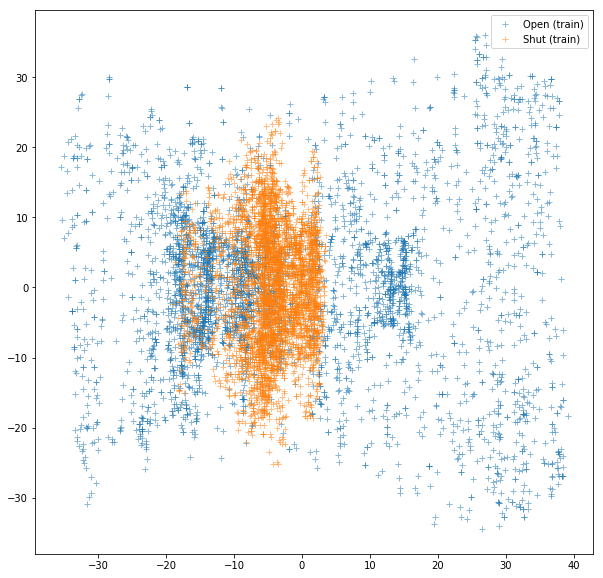

In [65]:
figure(figsize=(10,10))

k1,k2 =0,1
plot(coords[:Ltrain//2,k1], coords[:Ltrain//2,k2], '+',alpha=0.5)
plot(coords[Ltrain//2:,k1], coords[Ltrain//2:,k2], '+',alpha=0.5)
legend(['Open (train)', 'Shut (train)'])
#gcf()

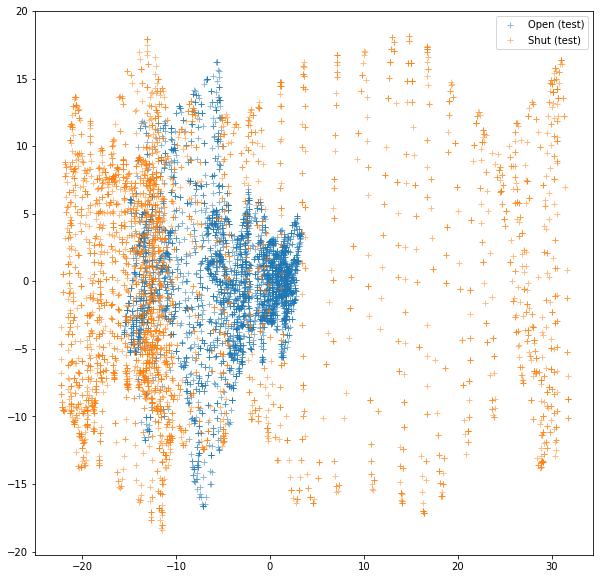

In [64]:
figure(figsize=(10,10))

k1,k2 = 0,1
plot(coords_test[:Ltest//2,k1], coords_test[:Ltest//2,k2], '+',alpha=0.5)
plot(coords_test[Ltest//2:,k1], coords_test[Ltest//2:,k2], '+',alpha=0.5)
legend(['Open (test)', 'Shut (test)'])
#gcf()

In [49]:
tsne = skm.TSNE()
mds = skm.MDS()

In [67]:
tr = tsne

In [68]:
%time mn_coords_train = tr.fit_transform(coords)

CPU times: user 1min 5s, sys: 239 ms, total: 1min 5s
Wall time: 1min 3s


In [69]:
%time mn_coords_test = tr.fit_transform(coords_test)

CPU times: user 53.7 s, sys: 43.9 ms, total: 53.8 s
Wall time: 51.8 s


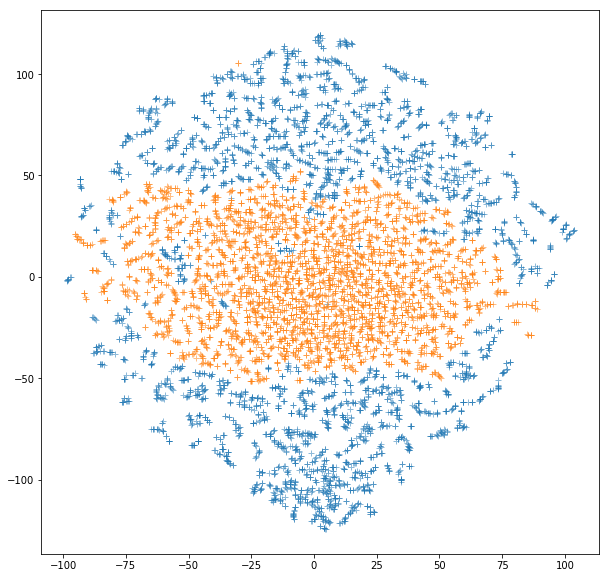

In [70]:
figure(figsize=(10,10))
plot(mn_coords_train[:Ltrain//2,0],mn_coords_train[:Ltrain//2,1],'+', alpha=0.5)
plot(mn_coords_train[Ltrain//2:,0],mn_coords_train[Ltrain//2:,1],'+', alpha=0.5)
#gcf()

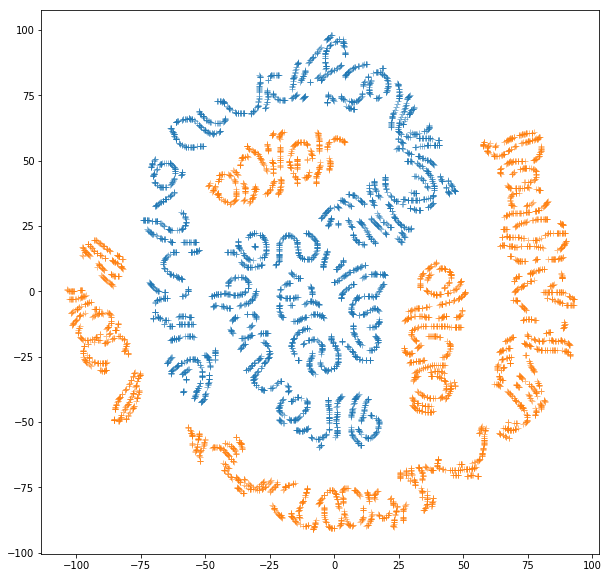

In [71]:
figure(figsize=(10,10))
plot(mn_coords_test[:Ltest//2,0],mn_coords_test[:Ltest//2,1],'+',alpha=0.5)
plot(mn_coords_test[Ltest//2:,0],mn_coords_test[Ltest//2:,1],'+',alpha=0.5)
#gcf()

In [72]:
close('all')